## **Modelo de BTD**

### **Utilidades**

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Métricas
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Optimización para MLE
from scipy.optimize import minimize

pd.set_option("display.max_colwidth", 140)
DATA_DIR = Path("data/clean")

def info(msg):
    print(f"[INFO] {msg}")

def require_cols(df, cols, name="df"):
    missing = set(cols) - set(df.columns)
    assert not missing, f"Faltan columnas en {name}: {missing}"

### **Carga robusta de datos**

In [2]:
TRAIN_CANDIDATES = [
    DATA_DIR / "train70.parquet",
    DATA_DIR / "train70_aug.parquet",   # si hiciste augment
    DATA_DIR / "train_clean.parquet",   # fallback
]

VAL_PATH  = DATA_DIR / "val15.parquet"
TEST_PATH = DATA_DIR / "test15.parquet"   # test interno (por prompt)

def load_split():
    # train
    df_train = None
    for p in TRAIN_CANDIDATES:
        if p.exists():
            df_train = pd.read_parquet(p)
            info(f"Train: {p}  shape={df_train.shape}")
            break
    assert df_train is not None, "No encontré ningún train parquet válido en data/clean/"

    # val
    assert VAL_PATH.exists(), f"No encontré {VAL_PATH}"
    df_val = pd.read_parquet(VAL_PATH)
    info(f"Val:   {VAL_PATH}  shape={df_val.shape}")

    # test (interno). Si no existe, seguimos igual.
    df_test = None
    if TEST_PATH.exists():
        df_test = pd.read_parquet(TEST_PATH)
        info(f"Test:  {TEST_PATH}  shape={df_test.shape}")
    else:
        info("Test interno no encontrado (ok).")

    return df_train, df_val, df_test

df_train, df_val, df_test = load_split()

# columnas mínimas
REQ = {"model_a","model_b","winner_model_a","winner_model_b","winner_tie"}
require_cols(df_train, REQ, "train")
require_cols(df_val,   REQ, "val")
if df_test is not None:
    require_cols(df_test,  REQ, "test")

[INFO] Train: data\clean\train70.parquet  shape=(22955, 12)
[INFO] Val:   data\clean\val15.parquet  shape=(17208, 12)
[INFO] Test:  data\clean\test15.parquet  shape=(17220, 12)


### **Preparación de outcomes y mapeos**

In [3]:
# outcome numérico: +1 (A gana), -1 (B gana), 0 (TIE)
def to_outcome(df):
    a = df["winner_model_a"].astype(int).to_numpy()
    b = df["winner_model_b"].astype(int).to_numpy()
    t = df["winner_tie"].astype(int).to_numpy()
    return np.where(t==1, 0, np.where(a==1, 1, -1))

y_tr = to_outcome(df_train)
y_va = to_outcome(df_val)
y_te = to_outcome(df_test) if df_test is not None else None

# vocabulario de modelos (desde TRAIN)
models_train = pd.Index(sorted(pd.unique(pd.concat([df_train["model_a"], df_train["model_b"]]))))
m2i = {m:i for i,m in enumerate(models_train)}
M = len(models_train)
info(f"Modelos en TRAIN: {M}")

def pair_indices(df, mapping):
    ia = df["model_a"].map(mapping)
    ib = df["model_b"].map(mapping)
    mask = ia.notna() & ib.notna()  # true si ambos modelos existen en el mapping
    return ia.astype("Int64").to_numpy(), ib.astype("Int64").to_numpy(), mask.to_numpy()

i_tr, j_tr, m_tr = pair_indices(df_train, m2i)
i_va, j_va, m_va = pair_indices(df_val,   m2i)
if df_test is not None:
    i_te, j_te, m_te = pair_indices(df_test, m2i)

# filtramos train por seguridad (en principio no debería haber NaN)
i_tr = i_tr[m_tr].astype(int); j_tr = j_tr[m_tr].astype(int); y_tr = y_tr[m_tr]


[INFO] Modelos en TRAIN: 64


### **BTD (Davidson) por MLE**

In [4]:
def unpack_theta(theta, M):
    # theta: [β_0, ..., β_{M-2}, z]
    beta_free = theta[:M-1]
    z = theta[-1]
    beta = np.concatenate([beta_free, np.array([0.0])])  # referencia
    tau  = np.exp(z)
    return beta, tau

def nll_btd(theta, i_idx, j_idx, y, l2=1e-3, eps=1e-12):
    beta, tau = unpack_theta(theta, M)
    pi = np.exp(beta)

    pi_i = pi[i_idx]
    pi_j = pi[j_idx]
    s_ij = np.sqrt(pi_i * pi_j)
    denom = pi_i + pi_j + 2.0 * tau * s_ij + eps

    pA = pi_i / denom
    pB = pi_j / denom
    pT = (2.0 * tau * s_ij) / denom

    # log-verosimilitud
    ll = (
        (y ==  1) * np.log(pA + eps) +
        (y == -1) * np.log(pB + eps) +
        (y ==  0) * np.log(pT + eps)
    )
    # Ridge sobre β (excepto ref)
    reg = l2 * np.sum(beta[:-1]**2)
    return -np.sum(ll) + reg

# inicialización: β=0 → π=1; z=log(τ) con τ≈0.1
theta0 = np.zeros(M)  # M-1 betas + z
theta0[-1] = np.log(0.1)

res = minimize(
    nll_btd,
    theta0,
    args=(i_tr.astype(int), j_tr.astype(int), y_tr),
    method="L-BFGS-B",
    options={"maxiter": 500, "ftol": 1e-8, "gtol": 1e-6, "disp": True},
)

beta_hat, tau_hat = unpack_theta(res.x, M)
strength = np.exp(beta_hat)
strength_norm = strength / strength.mean()

strength_df = pd.DataFrame({
    "model": models_train,
    "beta": beta_hat,
    "strength": strength,
    "strength_norm": strength_norm,
}).sort_values("strength_norm", ascending=False).reset_index(drop=True)

print(f"\nConvergió: {res.success},  NLL={res.fun:.4f},  τ (tie) ≈ {tau_hat:.6f}")
display(strength_df.head(10))


Convergió: True,  NLL=23855.7397,  τ (tie) ≈ 0.490347


,model,beta,strength,strength_norm
0,gpt-4-0125-preview,1.950273,7.030610,5.546196
1,gpt-4-1106-preview,1.799181,6.044693,4.768441
2,gpt-4-0314,1.182482,3.262461,2.573639
3,gpt-4-0613,0.928760,2.531368,1.996905
4,mistral-medium,0.895764,2.449206,1.932090
5,claude-1,0.748407,2.113631,1.667367
6,qwen1.5-72b-chat,0.719887,2.054201,1.620485
7,gemini-pro,0.705952,2.025774,1.598061
8,yi-34b-chat,0.568670,1.765916,1.393068
9,claude-2.1,0.556692,1.744891,1.376482


### **Funciones de predicción y evaluación**

In [5]:
def predict_probs(i_idx, j_idx, beta, tau, eps=1e-12):
    pi = np.exp(beta)
    pi_i = pi[i_idx]
    pi_j = pi[j_idx]
    s_ij = np.sqrt(pi_i * pi_j)
    denom = pi_i + pi_j + 2.0 * tau * s_ij + eps
    pA = pi_i / denom
    pB = pi_j / denom
    pT = (2.0 * tau * s_ij) / denom
    return np.vstack([pA, pB, pT]).T  # [n, 3]

def eval_split(name, i_idx, j_idx, mask, y_true):
    if i_idx is None:
        info(f"{name}: split no disponible.")
        return None
    # solo casos con modelos vistos en TRAIN
    idx = mask.astype(bool)
    i_ = i_idx[idx].astype(int)
    j_ = j_idx[idx].astype(int)
    yt = y_true[idx]

    probs = predict_probs(i_, j_, beta_hat, tau_hat)
    # 0:A, 1:B, 2:TIE
    pred_idx = np.argmax(probs, axis=1)
    y_pred = np.where(pred_idx==0, 1, np.where(pred_idx==1, -1, 0))

    # Métricas en etiquetas {A,B,TIE}
    lab = {1:"A", -1:"B", 0:"TIE"}
    yt_lbl = np.array([lab[v] for v in yt])
    yp_lbl = np.array([lab[v] for v in y_pred])
    acc = accuracy_score(yt_lbl, yp_lbl)
    f1m = f1_score(yt_lbl, yp_lbl, average="macro")
    f1w = f1_score(yt_lbl, yp_lbl, average="weighted")

    print(f"\n== {name} ==")
    print(f"Ejemplos evaluados (ambos modelos vistos en TRAIN): {len(yt_lbl)}")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | F1-weighted: {f1w:.4f}")
    print("\nClasification report:")
    print(classification_report(yt_lbl, yp_lbl, digits=4))
    print("Confusion matrix (A,B,TIE) rows=true cols=pred:")
    labs = ["A","B","TIE"]
    print(confusion_matrix(yt_lbl, yp_lbl, labels=labs))

    return {
        "name": name,
        "n_eval": len(yt_lbl),
        "accuracy": acc,
        "f1_macro": f1m,
        "f1_weighted": f1w,
    }

val_report = eval_split("VAL",  i_va, j_va, m_va, y_va)
test_report = eval_split("TEST", i_te if df_test is not None else None,
                         j_te if df_test is not None else None,
                         m_te if df_test is not None else None,
                         y_te if df_test is not None else None)



== VAL ==
Ejemplos evaluados (ambos modelos vistos en TRAIN): 17208
Accuracy: 0.4445 | F1-macro: 0.3509 | F1-weighted: 0.3627

Clasification report:
              precision    recall  f1-score   support

           A     0.4448    0.6432    0.5259      5947
           B     0.4442    0.6470    0.5268      5910
         TIE     0.0000    0.0000    0.0000      5351

    accuracy                         0.4445     17208
   macro avg     0.2963    0.4301    0.3509     17208
weighted avg     0.3063    0.4445    0.3627     17208

Confusion matrix (A,B,TIE) rows=true cols=pred:
[[3825 2122    0]
 [2086 3824    0]
 [2688 2663    0]]


c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


== TEST ==
Ejemplos evaluados (ambos modelos vistos en TRAIN): 17220
Accuracy: 0.4500 | F1-macro: 0.3539 | F1-weighted: 0.3691

Clasification report:
              precision    recall  f1-score   support

           A     0.4534    0.6523    0.5349      6022
           B     0.4466    0.6423    0.5269      5949
         TIE     0.0000    0.0000    0.0000      5249

    accuracy                         0.4500     17220
   macro avg     0.3000    0.4315    0.3539     17220
weighted avg     0.3128    0.4500    0.3691     17220

Confusion matrix (A,B,TIE) rows=true cols=pred:
[[3928 2094    0]
 [2128 3821    0]
 [2608 2641    0]]


c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\garci\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### **Guardados**

In [6]:
# Ranking de fuerzas
OUT_STRENGTHS = DATA_DIR / "btd_strengths.csv"
strength_df.to_csv(OUT_STRENGTHS, index=False, encoding="utf-8")
info(f"Ranking guardado en: {OUT_STRENGTHS.resolve()}")

# (Opcional) guardar predicciones por fila en VAL/TEST con probabilidades
def dump_preds(df, i_idx, j_idx, mask, split_name):
    idx = mask.astype(bool)
    i_ = i_idx[idx].astype(int)
    j_ = j_idx[idx].astype(int)
    probs = predict_probs(i_, j_, beta_hat, tau_hat)
    pred_idx = np.argmax(probs, axis=1)
    map_lbl = {0:"A", 1:"B", 2:"TIE"}
    pred_lbl = np.array([map_lbl[k] for k in pred_idx])

    out = df.loc[idx, ["model_a","model_b"]].copy()
    out["p_A"] = probs[:,0]
    out["p_B"] = probs[:,1]
    out["p_TIE"] = probs[:,2]
    out["pred"] = pred_lbl
    path = DATA_DIR / f"btd_preds_{split_name}.parquet"
    out.to_parquet(path, index=False)
    info(f"Predicciones {split_name} guardadas en: {path}")

dump_preds(df_val,  i_va, j_va, m_va, "val")
if df_test is not None:
    dump_preds(df_test, i_te, j_te, m_te, "test")


[INFO] Ranking guardado en: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\data\clean\btd_strengths.csv
[INFO] Predicciones val guardadas en: data\clean\btd_preds_val.parquet
[INFO] Predicciones test guardadas en: data\clean\btd_preds_test.parquet


### **Visual rápido de top/bottom por fuerza**

In [7]:
print("\nTop-15 modelos por 'strength_norm':")
display(strength_df.head(15))

print("\nBottom-15 modelos por 'strength_norm':")
display(strength_df.tail(15))


Top-15 modelos por 'strength_norm':


,model,beta,strength,strength_norm
0,gpt-4-0125-preview,1.950273,7.030610,5.546196
1,gpt-4-1106-preview,1.799181,6.044693,4.768441
2,gpt-4-0314,1.182482,3.262461,2.573639
3,gpt-4-0613,0.928760,2.531368,1.996905
4,mistral-medium,0.895764,2.449206,1.932090
5,claude-1,0.748407,2.113631,1.667367
6,qwen1.5-72b-chat,0.719887,2.054201,1.620485
7,gemini-pro,0.705952,2.025774,1.598061
8,yi-34b-chat,0.568670,1.765916,1.393068
9,claude-2.1,0.556692,1.744891,1.376482



Bottom-15 modelos por 'strength_norm':


,model,beta,strength,strength_norm
49,vicuna-7b,-0.487872,0.613931,0.484308
50,mistral-7b-instruct,-0.541839,0.581677,0.458864
51,koala-13b,-0.580100,0.559842,0.441640
52,chatglm3-6b,-0.943630,0.389212,0.307036
53,RWKV-4-Raven-14B,-1.206171,0.299341,0.236140
54,gpt4all-13b-snoozy,-1.234114,0.291093,0.229632
55,alpaca-13b,-1.242815,0.288571,0.227643
56,chatglm2-6b,-1.256626,0.284613,0.224521
57,mpt-7b-chat,-1.300743,0.272329,0.214831
58,oasst-pythia-12b,-1.541339,0.214094,0.168891


### **Calibración ligera**

In [9]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

_to_lbl = { 1:"A", -1:"B", 0:"TIE" }

def eval_with_scales(i_idx, j_idx, mask, y_true, gamma=1.0, lamb=1.0, return_all=False):
    idx = mask.astype(bool)
    i = i_idx[idx].astype(int); j = j_idx[idx].astype(int)
    yt = y_true[idx]
    probs = predict_probs(i, j, beta_hat * gamma, tau_hat * lamb)
    pred_idx = np.argmax(probs, axis=1)  # 0:A,1:B,2:TIE
    y_pred = np.where(pred_idx==0, 1, np.where(pred_idx==1, -1, 0))
    yt_lbl = np.array([_to_lbl[v] for v in yt])
    yp_lbl = np.array([_to_lbl[v] for v in y_pred])
    acc = accuracy_score(yt_lbl, yp_lbl)
    f1m = f1_score(yt_lbl, yp_lbl, average="macro")
    tie_rate = (yp_lbl=="TIE").mean()
    if return_all:
        return acc, f1m, tie_rate, yt_lbl, yp_lbl
    return acc, f1m, tie_rate

# tasa objetivo de TIE en VAL (ground truth)
target_tie = (np.array([_to_lbl[v] for v in y_va]) == "TIE").mean()
print(f"VAL: tie_rate objetivo ≈ {target_tie:.3f}")

def tune_lambda_for_tie(gamma, lo=1.0, hi=6.0, max_iter=24, tol=1e-3):
    # Búsqueda binaria suponiendo que la tasa de TIE crece con λ
    acc_lo, f1_lo, tie_lo = eval_with_scales(i_va, j_va, m_va, y_va, gamma, lo)
    acc_hi, f1_hi, tie_hi = eval_with_scales(i_va, j_va, m_va, y_va, gamma, hi)
    # si el objetivo está afuera del rango, devuelve el extremo más cercano
    if target_tie <= tie_lo: 
        return lo, (acc_lo, f1_lo, tie_lo)
    if target_tie >= tie_hi:
        return hi, (acc_hi, f1_hi, tie_hi)
    l, r = lo, hi
    best = None
    for _ in range(max_iter):
        mid = 0.5*(l+r)
        acc_m, f1_m, tie_m = eval_with_scales(i_va, j_va, m_va, y_va, gamma, mid)
        # guarda el que esté más cerca del objetivo
        cand = (abs(tie_m - target_tie), f1_m, acc_m, mid, tie_m)
        if (best is None) or (cand < best):
            best = cand
        if abs(tie_m - target_tie) < tol:
            break
        if tie_m < target_tie:
            l = mid
        else:
            r = mid
    _, f1_b, acc_b, lam_b, tie_b = best
    return lam_b, (acc_b, f1_b, tie_b)

# Explora pocos γ (compresión de betas) y sintoniza λ para igualar la tasa de TIE
gammas = [0.8, 0.9, 1.0]  # prueba rápida
candidatos = []
for g in gammas:
    lam, (acc, f1m, tie_r) = tune_lambda_for_tie(g)
    candidatos.append((f1m, acc, tie_r, g, lam))
    print(f"gamma={g:.2f} → lambda*={lam:.3f} | F1-macro={f1m:.4f} Acc={acc:.4f} tie_pred={tie_r:.3f}")

# Elige el de mejor F1-macro (con tie_rate ≈ objetivo)
best = max(candidatos, key=lambda x: x[0])
f1b, accb, tieb, gb, lb = best
print(f"\nMejor (VAL) → gamma={gb:.2f}, lambda={lb:.3f} | F1-macro={f1b:.4f}, Acc={accb:.4f}, tie_pred={tieb:.3f}")

# Evalúa TEST con ese (γ, λ)
if 'i_te' in globals():
    acc_t, f1m_t, tie_t = eval_with_scales(i_te, j_te, m_te, y_te, gamma=gb, lamb=lb)
    print(f"TEST → F1-macro={f1m_t:.4f}, Acc={acc_t:.4f}, tie_pred={tie_t:.3f}")

VAL: tie_rate objetivo ≈ 0.311
gamma=0.80 → lambda*=1.143 | F1-macro=0.4344 Acc=0.4378 tie_pred=0.310
gamma=0.90 → lambda*=1.159 | F1-macro=0.4344 Acc=0.4378 tie_pred=0.310
gamma=1.00 → lambda*=1.176 | F1-macro=0.4344 Acc=0.4378 tie_pred=0.310

Mejor (VAL) → gamma=0.80, lambda=1.143 | F1-macro=0.4344, Acc=0.4378, tie_pred=0.310
TEST → F1-macro=0.4433, Acc=0.4476, tie_pred=0.307


In [12]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

# --------- 1) Parámetros de calibración del BTD (los que encontraste) ----------
GAMMA  = 0.80
LAMBDA = 1.143
try:
    TAU = float(tau_hat)
except NameError:
    TAU = 0.490347  # tu τ reportado

print(f"[info] BTD: tau={TAU:.6f}, gamma={GAMMA}, lambda={LAMBDA}")

# --------- 2) Cargar betas desde CSV (model,beta) ----------
def find_strengths_csv():
    for p in [
        Path("btd_strengths.csv"),
        Path("artifacts_btd/btd_strengths.csv"),
        Path("data/btd_strengths.csv"),
        Path("data/clean/btd_strengths.csv"),
    ]:
        if p.exists():
            return p
    # búsqueda amplia
    hits = list(Path(".").glob("**/btd_strengths*.csv"))
    return hits[0] if hits else None

csv_path = find_strengths_csv()
if csv_path is None:
    raise FileNotFoundError("No encontré 'btd_strengths.csv' con columnas ['model','beta'].")

df_strengths = pd.read_csv(csv_path)
assert {"model","beta"}.issubset(df_strengths.columns), f"Faltan columnas en {csv_path}"
beta_dict = dict(zip(df_strengths["model"].astype(str), df_strengths["beta"].astype(float)))
print(f"[ok] Cargadas {len(beta_dict)} betas desde {csv_path}")

# --------- 3) Predicción BTD por NOMBRE (cuando hay model_a / model_b) ----------
def predict_btd_by_names(model_a_names, model_b_names, beta_map, tau, gamma=1.0, lamb=1.0):
    bA = np.array([beta_map.get(str(a), 0.0) for a in model_a_names], dtype=float) * gamma
    bB = np.array([beta_map.get(str(b), 0.0) for b in model_b_names], dtype=float) * gamma
    pi = np.exp(bA); pj = np.exp(bB)
    tau_eff = tau * lamb
    denom = pi + pj + 2.0 * tau_eff * np.sqrt(pi * pj)
    pA = pi / denom
    pB = pj / denom
    pT = 1.0 - pA - pB
    P = np.vstack([pA, pB, pT]).T
    P = np.clip(P, 1e-12, 1.0)
    P /= P.sum(axis=1, keepdims=True)
    return P  # columnas: [P(A), P(B), P(TIE)]

# --------- 4) Fallback por contenido (sin nombres de modelo) ----------
#   - mantiene tie_base ≈ 0.311 (de tu VAL)
#   - reduce tie cuando |lenA-lenB| aumenta (exp decaimiento)
#   - reparte (1 - tie) entre A/B con una logística por diferencia de longitudes
TIE_BASE = 0.311
ALPHA    = 1/800.0   # controla qué tan rápido baja el tie cuando las longitudes difieren
K_LOGIT  = 1/900.0   # pendiente de la logística para A vs B
MIN_TIE  = 0.05      # piso suave de tie

def predict_fallback_by_text(resp_a, resp_b, tie_base=TIE_BASE, alpha=ALPHA, k=K_LOGIT):
    la = resp_a.astype(str).str.len().to_numpy()
    lb = resp_b.astype(str).str.len().to_numpy()
    d  = la - lb
    ad = np.abs(d)

    # prob de TIE decrece con la diferencia de longitudes
    tie = tie_base * np.exp(-alpha * ad)
    tie = np.maximum(tie, MIN_TIE)

    # logística para A vs B
    pA_raw = 1.0 / (1.0 + np.exp(-k * d))
    pB_raw = 1.0 - pA_raw

    rest = 1.0 - tie
    pA = rest * pA_raw
    pB = rest * pB_raw
    P  = np.vstack([pA, pB, tie]).T
    P  = np.clip(P, 1e-9, 1.0)
    P /= P.sum(axis=1, keepdims=True)
    return P

# --------- 5) Cargar test externo y generar submission ----------
OUTDIR = Path("artifacts_btd"); OUTDIR.mkdir(parents=True, exist_ok=True)
EXT = Path("data/clean/test_external.parquet")
ALT = Path("data/test.csv")

if not EXT.exists() and ALT.exists():
    # Soporte alternativo si tienes el CSV original
    df_ext = pd.read_csv(ALT)
else:
    df_ext = pd.read_parquet(EXT)

print(f"[info] test externo columnas: {list(df_ext.columns)}")

need_text = {"id","response_a","response_b"}
has_models = {"model_a","model_b"}.issubset(df_ext.columns)
has_text   = need_text.issubset(df_ext.columns)

if has_models:
    # Caso 1: tenemos nombres → usar BTD
    P = predict_btd_by_names(
        df_ext["model_a"].astype(str).tolist(),
        df_ext["model_b"].astype(str).tolist(),
        beta_dict, TAU, GAMMA, LAMBDA
    )
    print("[ok] Predicción con BTD por nombres de modelo.")
elif has_text:
    # Caso 2: no hay nombres → fallback por contenido
    P = predict_fallback_by_text(df_ext["response_a"], df_ext["response_b"])
    print("[ok] Predicción con Fallback por contenido (sin model_a/model_b).")
else:
    raise ValueError(
        "El test externo no tiene ni ['model_a','model_b'] ni ['id','response_a','response_b'].\n"
        f"Columnas presentes: {list(df_ext.columns)}"
    )

sub = pd.DataFrame({
    "id": df_ext["id"].values,
    "winner_model_a": P[:,0],
    "winner_model_b": P[:,1],
    "winner_tie":     P[:,2],
})
sub_path = OUTDIR / "sample_submission_btd.csv"
sub.to_csv(sub_path, index=False)
print(f"[OK] sample_submission → {sub_path}")

# (opcional) guardo también las probabilidades completas por si quieres auditar
prob_path = OUTDIR / "test_external_probs.csv"
pd.DataFrame(P, columns=["pA","pB","pT"]).to_csv(prob_path, index=False)
print(f"[OK] probs → {prob_path}")

[info] BTD: tau=0.490347, gamma=0.8, lambda=1.143
[ok] Cargadas 64 betas desde data\clean\btd_strengths.csv
[info] test externo columnas: ['id', 'prompt', 'response_a', 'response_b']
[ok] Predicción con Fallback por contenido (sin model_a/model_b).
[OK] sample_submission → artifacts_btd\sample_submission_btd.csv
[OK] probs → artifacts_btd\test_external_probs.csv


[OK] Guardado: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\reports\btd\metrics_summary.csv


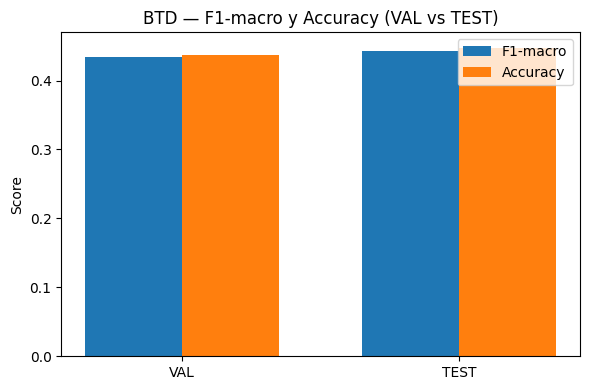

[OK] Guardado: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\reports\btd\plot_btd_metrics.png


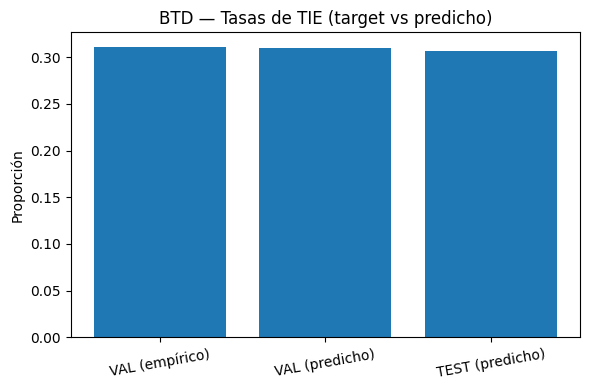

[OK] Guardado: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\reports\btd\plot_btd_tie_rates.png


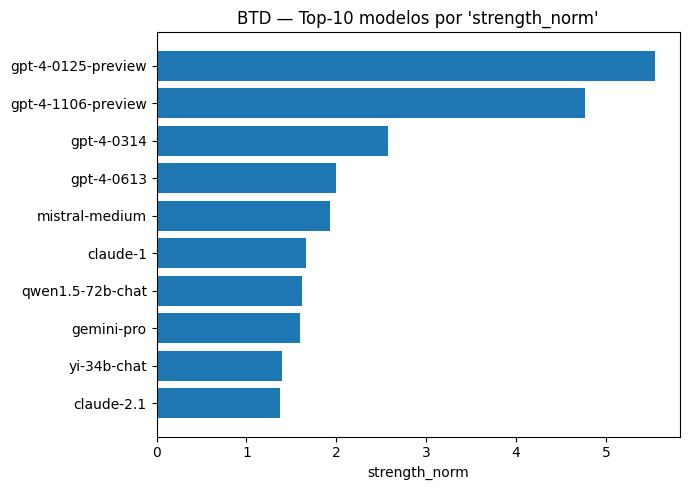

[OK] Guardado: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\reports\btd\plot_btd_top10_strengths.png
[OK] Guardado: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\proyecto2ds\reports\btd\metrics_summary.txt


In [13]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1) Parámetros / métricas (EDITABLES si cambian)
# ---------------------------
VAL_F1   = 0.4344
VAL_ACC  = 0.4378
VAL_TIE_EMPIRICO = 0.311
VAL_TIE_PRED     = 0.310

TEST_F1  = 0.4433
TEST_ACC = 0.4476
TEST_TIE_PRED    = 0.307

# Archivo con fuerzas BTD (betas / strength_norm)
STRENGTHS_CANDIDATES = [
    Path("data/clean/btd_strengths.csv"),
    Path("artifacts_btd/btd_strengths.csv"),
    Path("btd_strengths.csv"),
]

# Carpeta de salida
OUTDIR = Path("reports/btd")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# 2) Tabla de métricas y guardado
# ---------------------------
df_metrics = pd.DataFrame({
    "split": ["VAL", "TEST"],
    "f1_macro": [VAL_F1, TEST_F1],
    "accuracy": [VAL_ACC, TEST_ACC],
    "tie_pred": [VAL_TIE_PRED, TEST_TIE_PRED],
})
metrics_csv = OUTDIR / "metrics_summary.csv"
df_metrics.to_csv(metrics_csv, index=False)

print(f"[OK] Guardado: {metrics_csv.resolve()}")

# ---------------------------
# 3) Visualización #1 — F1 vs Accuracy (VAL/TEST)
# ---------------------------
plt.figure(figsize=(6,4))
x = np.arange(len(df_metrics["split"]))
w = 0.35
plt.bar(x - w/2, df_metrics["f1_macro"], w, label="F1-macro")
plt.bar(x + w/2, df_metrics["accuracy"], w, label="Accuracy")
plt.xticks(x, df_metrics["split"])
plt.ylabel("Score")
plt.title("BTD — F1-macro y Accuracy (VAL vs TEST)")
plt.legend()
plt.tight_layout()
plot1_path = OUTDIR / "plot_btd_metrics.png"
plt.savefig(plot1_path, dpi=150)
plt.show()
print(f"[OK] Guardado: {plot1_path.resolve()}")

# ---------------------------
# 4) Visualización #2 — TIE rates (empírico vs predicho)
# ---------------------------
plt.figure(figsize=(6,4))
labels = ["VAL (empírico)", "VAL (predicho)", "TEST (predicho)"]
values = [VAL_TIE_EMPIRICO, VAL_TIE_PRED, TEST_TIE_PRED]
plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=10)
plt.ylabel("Proporción")
plt.title("BTD — Tasas de TIE (target vs predicho)")
plt.tight_layout()
plot2_path = OUTDIR / "plot_btd_tie_rates.png"
plt.savefig(plot2_path, dpi=150)
plt.show()
print(f"[OK] Guardado: {plot2_path.resolve()}")

# ---------------------------
# 5) Visualización #3 — Top-10 por strength_norm
# ---------------------------
strengths_path = None
for cand in STRENGTHS_CANDIDATES:
    if cand.exists():
        strengths_path = cand
        break

if strengths_path is None:
    print("[WARN] No encontré 'btd_strengths.csv' en data/clean/ ni artifacts_btd/ ni cwd; se omite gráfico Top-10.")
else:
    df_str = pd.read_csv(strengths_path)
    # Si no trae 'strength_norm' pero sí 'beta', generamos una escala monótona para visualizar
    if "strength_norm" not in df_str.columns and "beta" in df_str.columns:
        df_str["strength_norm"] = np.exp(df_str["beta"])
    # Filtrar columnas necesarias
    need = [c for c in ["model", "strength_norm"] if c in df_str.columns]
    df_str = df_str[need].dropna()
    # Top-10
    df_top = df_str.sort_values("strength_norm", ascending=False).head(10)
    plt.figure(figsize=(7,5))
    plt.barh(df_top["model"][::-1], df_top["strength_norm"][::-1])
    plt.xlabel("strength_norm")
    plt.title("BTD — Top-10 modelos por 'strength_norm'")
    plt.tight_layout()
    plot3_path = OUTDIR / "plot_btd_top10_strengths.png"
    plt.savefig(plot3_path, dpi=150)
    plt.show()
    print(f"[OK] Guardado: {plot3_path.resolve()}")

# ---------------------------
# 6) Extra: resumen de texto
# ---------------------------
summary_txt = OUTDIR / "metrics_summary.txt"
with open(summary_txt, "w", encoding="utf-8") as f:
    f.write("BTD — resultados calibrados\n")
    f.write(f"VAL : F1-macro={VAL_F1:.4f}, Acc={VAL_ACC:.4f}, Tie_pred={VAL_TIE_PRED:.3f}, Tie_emp={VAL_TIE_EMPIRICO:.3f}\n")
    f.write(f"TEST: F1-macro={TEST_F1:.4f}, Acc={TEST_ACC:.4f}, Tie_pred={TEST_TIE_PRED:.3f}\n")
print(f"[OK] Guardado: {summary_txt.resolve()}")